In [1]:
#Mounting the google drive as the images were uploaded to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#Train set directory
Train_dir = '/content/drive/MyDrive/Weed_Clasification/Weed_Data_Set/WeedID10' #Replace with the directory of the training dataset

#Managing and spliting the datase (80% for training, 20% for validation)
img_size = 224
batch = 32
AUTOTUNE = tf.data.AUTOTUNE

#80% for training
train_ds = tf.keras.utils.image_dataset_from_directory(
    Train_dir,
    seed=123,
    validation_split=0.2,
    subset='training',
    batch_size=batch,
    image_size=(img_size, img_size)
)

# Extracting class names and number
class_names = train_ds.class_names
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))

#20% for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    Train_dir,
    seed=123,
    validation_split=0.2,
    subset='validation',
    batch_size=batch,
    image_size=(img_size, img_size)
)

# Enable prefetching and shuffling
train_ds = train_ds.shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



Found 3578 files belonging to 10 classes.
Using 2863 files for training.
Class Names: ['Carpetweed', 'Eclipta', 'Goosegrass', 'Morningglory', 'Nutsedge', 'PalmerAmaranth', 'Purslane', 'Sicklepod', 'SpottedSpurge', 'Waterhemp']
Number of Classes: 10
Found 3578 files belonging to 10 classes.
Using 715 files for validation.


In [3]:
# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal", input_shape=(224, 224, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Retain class names after applying map
train_ds.class_names = class_names

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
#Double checking if train_ds exists and has class_names
if hasattr(train_ds, 'class_names'):
    print("Class Names:", train_ds.class_names)
else:
    print("Error: train_ds does not have class_names. Verify dataset creation.")

Class Names: ['Carpetweed', 'Eclipta', 'Goosegrass', 'Morningglory', 'Nutsedge', 'PalmerAmaranth', 'Purslane', 'Sicklepod', 'SpottedSpurge', 'Waterhemp']


In [5]:
model = Sequential([
    data_augmentation,
    Rescaling(1./255),  # Normalize pixel values
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,447,530 (24.60 MB)

 Trainable params: 6,447,530 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#Some preliminary Adjustments before training

#Early stopping to stop the training and prevent overfitting when there is no significant improvement in each epoch

# Directory for saving checkpoints (saved temporaryly)
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Defining callbacks
adaptive_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Early stopping to halt training when no improvement
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop if no improvement after 3 epochs
    restore_best_weights=True  # Restore the best weights in memory
)


#For large number of epoch the karnel sometimes dies. that is why data is saved after each 10 epoch.
#for storage limitation, previous checkpoint is cleaned up whwn new check point arrives

# Custom cleanup callback to manage intermediate checkpoints
class CleanUpCheckpoints(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_dir, epoch_interval):
        super().__init__()
        self.checkpoint_dir = checkpoint_dir
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        # Saveing intermediate checkpoints every `epoch_interval` epochs
        if (epoch + 1) % self.epoch_interval == 0:
            current_checkpoint = os.path.join(self.checkpoint_dir, f"model_epoch_{epoch + 1}.keras")
            self.model.save(current_checkpoint)

            # Deleting older checkpoints
            for file in os.listdir(self.checkpoint_dir):
                if file.startswith("model_epoch_") and file != f"model_epoch_{epoch + 1}.h5":
                    os.remove(os.path.join(self.checkpoint_dir, file))
                    print(f"Deleted old checkpoint: {file}")


cleanup_callback = CleanUpCheckpoints(checkpoint_dir=checkpoint_dir, epoch_interval=10)

In [7]:
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[cleanup_callback,early_stopping])

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 99s 220ms/step - accuracy: 0.2109 - loss: 2.2925 - val_accuracy: 0.2951 - val_loss: 1.9775
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3165 - loss: 1.9127 - val_accuracy: 0.3874 - val_loss: 1.8181
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3501 - loss: 1.8210 - val_accuracy: 0.3357 - val_loss: 1.9045
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4302 - loss: 1.6698 - val_accuracy: 0.4266 - val_loss: 1.6362
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4507 - loss: 1.5579 - val_accuracy: 0.3790 - val_loss: 1.8530
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4879 - loss: 1.4791 - val_accuracy: 0.4490 - val_loss: 1.5258
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5092 - loss: 1.3700 - val_accuracy: 0.4979 - val_loss: 1.4834
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5384 - loss: 1.3528 - val_accuracy: 

In [8]:
#Saving

# Saving the final model locally after fine-tuning
final_model_path = os.path.join(checkpoint_dir, "final_modelSequential_Basic.keras")
model.save(final_model_path)
print(f"Final model saved at: {final_model_path}")

#Saving the model in Google Drive

# Defining the Google Drive path
drive_path = "/content/drive/MyDrive/Weed_Clasification/DL_Models/Sequential_Basic/h5_file" #Replace with the directory where the (.h5) model needs to be saved in the Google Drive
# Copying the file to Google Drive as(.h5)
shutil.copy(final_model_path, drive_path)
print(f"Final model also saved to Google Drive at: {drive_path}") #Model saved as (.h5). If the model is saved as (.keras), it provides erroneus evaluation report

# Saving the class names
import json
with open("/content/drive/MyDrive/Weed_Clasification/DL_Models/Sequential_Basic/class_names.json", 'w') as f:  #Replace with the directory where the (.json) file containing class information needs to be saved in the Google Drive
    json.dump(class_names, f)

Final model saved at: checkpoints/final_modelSequential_Basic.keras
Final model also saved to Google Drive at: /content/drive/MyDrive/Weed_Clasification/DL_Models/Sequential_Basic/h5_file


In [9]:
#Traing Evaluation

#Loading the trained model
final_model_path = os.path.join(checkpoint_dir, "final_modelSequential_Basic.keras")
final_model = tf.keras.models.load_model(final_model_path)

# Evaluating the final model on validation data
final_val_loss, final_val_accuracy = final_model.evaluate(val_ds)
print(f"Final Model - Validation Loss: {final_val_loss}")
print(f"Final Model - Validation Accuracy: {final_val_accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7267 - loss: 0.9085
Final Model - Validation Loss: 0.9030715823173523
Final Model - Validation Accuracy: 0.7454545497894287


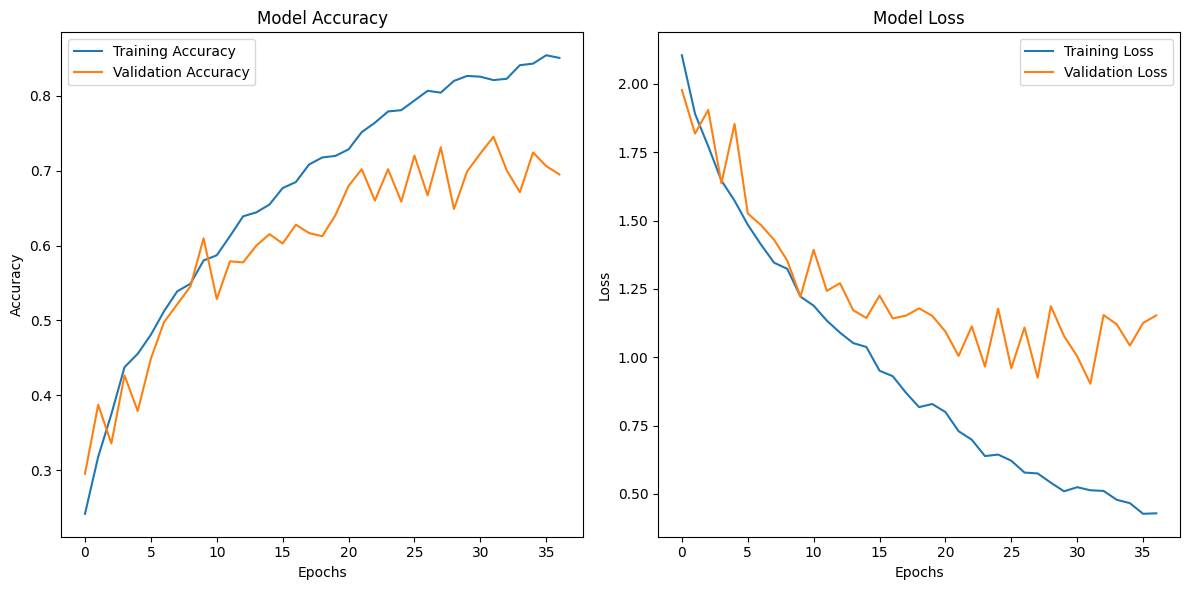

In [10]:
#Ploting training history for visualization of accuracy and loss of traing and validation

def plot_training_history(history):

    plt.figure(figsize=(12, 6))

    # Ploting training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Ploting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)  # Initial training with freeze layer


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


<Figure size 800x800 with 0 Axes>

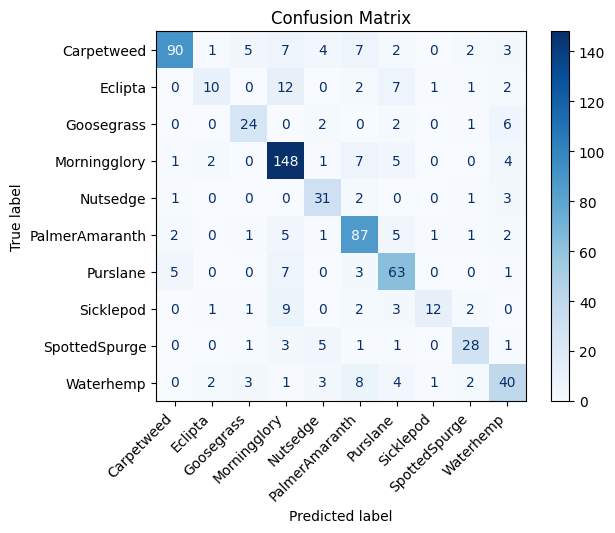

In [11]:
#Creating Confusion Matrix for training dataset

def plot_confusion_matrix(final_model, val_ds, class_names):

    y_pred = []
    y_true = []

    # Collecting predictions and true labels
    for images, labels in val_ds:
        preds = final_model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))  # Predicted class indices
        y_true.extend(labels.numpy())           # True class indices

    # Ensuring class names match the number of classes
    if len(class_names) < len(set(y_true)):
        raise ValueError("Number of class names does not match the number of unique classes in the labels.")

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display of confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    # Rotating x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')  # Rotating by 45 degrees and aligning to the right
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(final_model, val_ds, class_names=class_names) #Confusion matrix for training dataset


In [12]:
#Evaluation of the model for unseen test dataset

# Defining the test dataset path
test_dir = '/content/drive/MyDrive/Weed_Clasification/Competition set renamed' ##Replace with the test dataset directory. the test data should be organized properly simillar to the train dataset

# Image size and batch size
img_size = 224
batch_size = 32

# Loading the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False  # No need to shuffle for evaluation
)

# Prefetching the test dataset
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Loading the final model
final_model_path = os.path.join("checkpoints", "final_modelSequential_Basic.keras")
final_model = tf.keras.models.load_model(final_model_path)

# Evaluating the final model on the test dataset
final_test_loss, final_test_accuracy = final_model.evaluate(test_ds)

# Print the results
print(f"Final Model - Test Loss: {final_test_loss}")
print(f"Final Model - Test Accuracy: {final_test_accuracy}")

Found 164 files belonging to 10 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 779ms/step - accuracy: 0.6903 - loss: 1.3229
Final Model - Test Loss: 1.3391008377075195
Final Model - Test Accuracy: 0.6890243887901306


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


<Figure size 1000x1000 with 0 Axes>

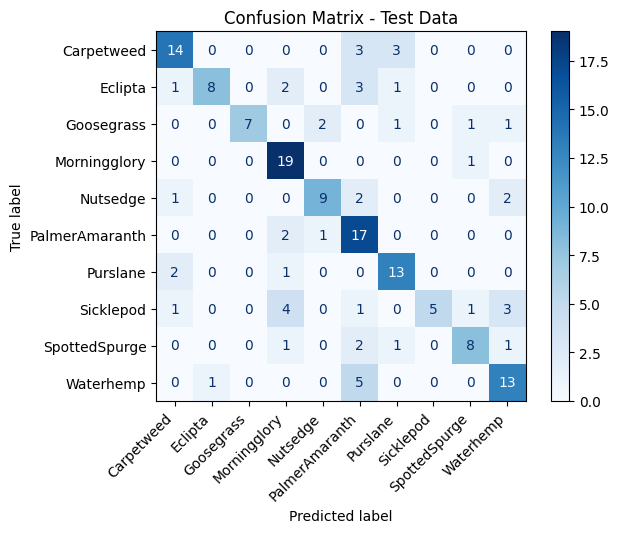

Classification Report:
                precision    recall  f1-score   support

    Carpetweed       0.74      0.70      0.72        20
       Eclipta       0.89      0.53      0.67        15
    Goosegrass       1.00      0.58      0.74        12
  Morningglory       0.66      0.95      0.78        20
      Nutsedge       0.75      0.64      0.69        14
PalmerAmaranth       0.52      0.85      0.64        20
      Purslane       0.68      0.81      0.74        16
     Sicklepod       1.00      0.33      0.50        15
 SpottedSpurge       0.73      0.62      0.67        13
     Waterhemp       0.65      0.68      0.67        19

      accuracy                           0.69       164
     macro avg       0.76      0.67      0.68       164
  weighted avg       0.74      0.69      0.68       164



In [13]:
#Confusion matrix for test dataset

# Generateing predictions and confusion matrix
y_pred_test = []  # Local variable for test predictions
y_true_test = []  # Local variable for test true labels

for images, labels in test_ds:
    preds = final_model.predict(images)
    y_pred_test.extend(np.argmax(preds, axis=1))  # Predicted class indices
    y_true_test.extend(labels.numpy())           # True class indices

# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotating by 45 degrees and aligning to the right

plt.title('Confusion Matrix - Test Data')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))


In [14]:
# Converting predictions to class names
predicted_classes = [class_names[i] for i in y_pred_test]
true_classes = [class_names[i] for i in y_true_test]

#Printing all predictions
print("\nPredictions for Test Dataset:")
for i, (true_class, pred_class) in enumerate(zip(true_classes, predicted_classes)):
    print(f"Image {i+1}: True Class = {true_class}, Predicted Class = {pred_class}")



Predictions for Test Dataset:
Image 1: True Class = Carpetweed, Predicted Class = Carpetweed
Image 2: True Class = Carpetweed, Predicted Class = Carpetweed
Image 3: True Class = Carpetweed, Predicted Class = Carpetweed
Image 4: True Class = Carpetweed, Predicted Class = Carpetweed
Image 5: True Class = Carpetweed, Predicted Class = Carpetweed
Image 6: True Class = Carpetweed, Predicted Class = Carpetweed
Image 7: True Class = Carpetweed, Predicted Class = Purslane
Image 8: True Class = Carpetweed, Predicted Class = Carpetweed
Image 9: True Class = Carpetweed, Predicted Class = Carpetweed
Image 10: True Class = Carpetweed, Predicted Class = Carpetweed
Image 11: True Class = Carpetweed, Predicted Class = Purslane
Image 12: True Class = Carpetweed, Predicted Class = PalmerAmaranth
Image 13: True Class = Carpetweed, Predicted Class = Carpetweed
Image 14: True Class = Carpetweed, Predicted Class = Carpetweed
Image 15: True Class = Carpetweed, Predicted Class = Carpetweed
Image 16: True Cla